# Finding similar movies in the MovieLens datset

Can we find an embedding space built on the movielens dataset to compare distance between titles?

Consider each person's viewing history as a series of titles.
Build a model to predict the next title watched based on the ones before it.
Or build a model to predict the middle title based on the ones either side.

Represent the titles as an embedding vector.
Build a dense layer on top of the embedding vector to predict the next title.

Follow an approach similar to Word2Vec.
Instead of treating each word as an entity or token, we use each title.
We treat the vocabulary as the set of titles.

1. Load the movielens dataset
2. Convert each movie title to an integer token
3. Create an embedding layer on the tokens
4. 

References:
* https://en.wikipedia.org/wiki/Word2vec

Start by importing stuff:

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.style.use("seaborn-v0_8-whitegrid")

## Load data

Load the movielens dataset.

In [ ]:
url = "https://files.grouplens.org/datasets/movielens/ml-25m.zip"
local_path = "/Users/stantoon/Downloads/ml-25m"

array([-0.01289366,  0.951     ,  0.431     ,  0.058     ,  0.009     ])

In [14]:
import requests
import zipfile
import pathlib


local_path = "/Users/stantoon/Downloads/ml-25m"
data_path = pathlib.Path().absolute() / "data" / "ml-25m"
data_zip_path = pathlib.Path().absolute() / "data" / "ml-25m.zip"


def download_data():
    # download to disk if not present already
    data_path.parent.mkdir(parents=True, exist_ok=True)

    if not data_path.is_file():
        if not data_zip_path.is_file():
            data_url = "https://files.grouplens.org/datasets/movielens/ml-25m.zip"
            with open(data_zip_path, "wb") as f:
                f.write(requests.get(data_url).content)
        with zipfile.ZipFile(data_zip_path, "r") as zip_file:
            zip_file.extractall(data_path.parent)


download_data()


def get_movie_names():
    return pd.read_csv(data_path / "movies.csv")

def get_ratings():
    df = pd.read_csv(data_path / "ratings.csv")
    df = df.sort_values(['userId','timestamp'])
    return df


names_df = get_movie_names()
ratings_df = get_ratings()
ratings_df

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


Each person has rated at least 20 titles.

In [16]:
ratings_df['userId'].value_counts()

userId
72315     32202
80974      9178
137293     8913
33844      7919
20055      7488
          ...  
12094        20
119539       20
156759       20
12084        20
36207        20
Name: count, Length: 162541, dtype: int64

## Build model architecture

We will build the embedding using word2vec. There are two forms:

1. Continuous Bag of Words (CBOW):
In CBOW, the model predicts the current word (target word) based on the context words within a fixed window size.

1. Skip-gram:
In Skip-gram, the model predicts context words (surrounding words) given the current word (target word).

The input to the model is a one-hot encoded vector representing the context words.
The hidden layer is a projection layer (embedding layer) that converts the one-hot encoded vectors into dense embedding vectors.
The output layer predicts the probability distribution of the target word given the context.
The model is trained to minimize the difference between the predicted probabilities and the actual word (softmax output).
CBOW is generally faster to train compared to Skip-gram, especially when using small training datasets.

In our case the words are actually movies.

The input to the model is a series of tokens representing the movies.
(These are converted to one-hot encoded vectors. Not needed?)
The tokens are converted into embedding vectors.

The embedding vectors of the context words are averaged to obtain a single context vector.
This context vector represents the overall context of the surrounding words.
The context vector is then passed through a linear transformation followed by a softmax activation function to produce a probability distribution over the entire vocabulary.

We then use a dense layer(s) to find the probability of each element in the vocabulary.
We compare against the true target word and use cross entropy loss to train the model weights, including the embedding layer.

We will use CBOW for this test as hopefully its faster and more appropriate on a smallish training dataset.
Therefore we need to define a window of entities to train over. We will start with 3, so predict the current entity given the one before and the one after.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Word2Vec model
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output = self.linear(embedded)
        return output

# Example movie titles dataset
titles_data = [[1, 2, 3, ...], [4, 5, 6, ...], ...]  # Sample encoded movie titles

# Hyperparameters
vocab_size = 10000  # Example vocabulary size
embedding_dim = 100  # Example embedding dimension
learning_rate = 0.001
num_epochs = 10

# Initialize model
model = Word2Vec(vocab_size, embedding_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    print(epoch)
    for title_data in titles_data:
        
        inputs = torch.tensor(title_data[:-1], dtype=torch.long)
        targets = torch.tensor(title_data[1:], dtype=torch.long)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs.view(-1, vocab_size), targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Get word embeddings
word_embeddings = model.embedding.weight.data.numpy()


TypeError: 'ellipsis' object cannot be interpreted as an integer

In [7]:
model(torch.tensor([1])).shape

torch.Size([1, 10000])

## Ratings based
The above Word2Vec approach will be assuming that people watched films that are similar in succession.

We have explicit ratings in the dataset we can use for a better indication.
We are assuming that people rate highly movies that are similar.

We also have genre information, how can we exploit this?

## Train models

In [4]:
models = {}
y_train_est = {}
y_test_est = {}

Split train/test

In [5]:
x_train = x[: n // 2]
x_test = x[n // 2 :]
y_train = y[: n // 2]
y_test = y[n // 2 :]

### Linear models

In [6]:
import sklearn.linear_model

models["linear"] = []
y_train_est["linear"] = []
y_test_est["linear"] = []
for _col in range(y.shape[1]):
    print(y_train[:, _col].shape)
    if _col in col_reg:
        _model = sklearn.linear_model.LinearRegression()
        _model.fit(x_train, y_train[:, _col])
        _y_train_est = _model.predict(x_train)
        _y_test_est = _model.predict(x_test)
    elif _col in col_class:
        _model = sklearn.linear_model.LogisticRegression()
        _model.fit(x_train, y_train[:, _col])
        _y_train_est = _model.predict_proba(x_train)[:, 1]
        _y_test_est = _model.predict_proba(x_test)[:, 1]
    y_train_est["linear"].append(_y_train_est)
    y_test_est["linear"].append(_y_test_est)
    models["linear"].append(_model)

y_train_est["linear"] = np.stack(y_train_est["linear"]).transpose()
y_test_est["linear"] = np.stack(y_test_est["linear"]).transpose()


(500,)
(500,)
(500,)
(500,)
(500,)


### GBMs

Fit GBMs to each output

In [7]:
import sklearn.ensemble

models["gbm"] = []
y_train_est["gbm"] = []
y_test_est["gbm"] = []
for _col in range(y.shape[1]):
    print(y_train[:, _col].shape)
    if _col in col_reg:
        _model = sklearn.ensemble.GradientBoostingRegressor()
        _model.fit(x_train, y_train[:,_col])
        _y_train_est = _model.predict(x_train)
        _y_test_est = _model.predict(x_test)
    elif _col in col_class:
        _model = sklearn.ensemble.GradientBoostingClassifier()
        _model.fit(x_train, y_train[:,_col])
        _y_train_est = _model.predict_proba(x_train)[:,1]
        _y_test_est = _model.predict_proba(x_test)[:,1]
    y_train_est["gbm"].append(_y_train_est)
    y_test_est["gbm"].append(_y_test_est)
    models["gbm"].append(_model)

y_train_est["gbm"] = np.stack(y_train_est["gbm"]).transpose()
y_test_est["gbm"] = np.stack(y_test_est["gbm"]).transpose()


(500,)
(500,)
(500,)
(500,)
(500,)


## Train multi-task neural net

Next we prep data for PyTorch by converting to Tensors and
creating dataloaders.

We need to use the whole dataset in each step rather than smaller batches to match the way
sklearn has it's cost function setup.

In [8]:
import torch.utils.data

x_train_t = torch.Tensor(x_train)
y_train_t = torch.Tensor(y_train)
x_test_t = torch.Tensor(x_test)
y_test_t = torch.Tensor(y_test)

dataset_train = torch.utils.data.TensorDataset(x_train_t, y_train_t)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=x_train_t.shape[0], shuffle=True)
dataset_test = torch.utils.data.TensorDataset(x_test_t, y_test_t)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=x_test_t.shape[0], shuffle=True)

### Model definition

Each output head should output a distribution so that we can measure the loglikelihood.
Or each output head should output a scalar.

In [9]:
import pytorch_lightning as pl
import torch


def get_dense_mlp(layer_size: list[int]) -> torch.nn.Sequential:
    """
    Builds pairs of (Linear, Relu) and a final Linear.
    """

    dense_layers = []
    for _idx in range(len(layer_size) - 2):
        dense_layers.append(torch.nn.Linear(layer_size[_idx], layer_size[_idx + 1]))
        dense_layers.append(torch.nn.ReLU())
    return torch.nn.Sequential(
        *dense_layers, torch.nn.Linear(layer_size[-2], layer_size[-1])
    )


def get_output_head_layers(emb_size: int, col_type: str):
    # general output head layers
    output_layers = get_dense_mlp([emb_size, 4, 1])
    return output_layers

    if 0:
        # outcome specific layer
        if col_type == "reg":
            return torch.nn.Sequential(
                *output_layers, torch.nn.Linear(output_size[-1], 1)
            )

            # mean = self.mean_linear(outputs)
            # scale = torch.nn.functional.softplus(self.scale_linear(outputs))
        if col_type == "class":
            return torch.nn.Sequential(
                *output_layers, torch.nn.Linear(output_size[-1], 1)
            )


class MLTNN(pl.LightningModule):
    def __init__(
        self,
        col_reg: list[int],
        col_class: list[int],
        n_inputs: int = 1,
        learning_rate=0.05,
    ):
        super().__init__()

        self.learning_rate = learning_rate
        self.train_log = []
        self.val_log = []

        n_outputs = max(col_reg + col_class) + 1
        self.loss_fcns = []
        for _idx in range(n_outputs):
            if _idx in col_reg:
                self.loss_fcns.append(torch.nn.MSELoss())
            if _idx in col_class:
                self.loss_fcns.append(torch.nn.BCEWithLogitsLoss())

        # embedding
        emb_size = 8
        self.embedding = get_dense_mlp([n_inputs, 64, 32, 16, emb_size])

        # output head for each output
        self.output_heads = []
        n_outputs = max(col_reg + col_class) + 1
        for _idx in range(n_outputs):
            self.output_heads.append(get_dense_mlp([emb_size, 1]))

            # _output_layers = _get_output_head_layers(col_type="reg" if _idx in col_reg else "class")
            # self.output_heads.append(_output_layers)

    def forward(self, x):
        emb = self.embedding(x)
        return torch.concat(
            [_output_head(emb) for _output_head in self.output_heads], dim=1
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx=None):
        x, y = batch
        y_hat = self(x)

        loss = torch.tensor(0.0)
        losses = []
        for _idx, _loss in enumerate(self.loss_fcns):
            losses.append(_loss(y_hat[:, _idx], y[:, _idx]))
            loss += losses[-1]

        self.log("loss", loss)
        self.train_log.append([_loss.detach().numpy() for _loss in losses])
        return loss

    def validation_step(self, batch, batch_idx=None):
        x, y = batch
        y_hat = self(x)

        loss = torch.tensor(0.0)
        losses = []
        for _idx, _loss in enumerate(self.loss_fcns):
            losses.append(_loss(y_hat[:, _idx], y[:, _idx]))
            loss += losses[-1]

        self.log("val_loss", loss)
        self.val_log.append([_loss.detach().numpy() for _loss in losses])

        return loss


def plot_convergence(train_loss):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(train_loss)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Train loss")
    fig.show()


def loss_fn_loglike(y_hat, y):
    negloglik = -y_hat.log_prob(y)
    return torch.mean(negloglik)


model = MLTNN(n_inputs=x_dim, col_reg=col_reg, col_class=col_class)
model.output_heads
model


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MLTNN(
  (embedding): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
  )
)

In [10]:
model(x_train_t)
x_batch, y_batch = next(iter(dataloader_train))
model.training_step((x_batch, y_batch))


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/core/module.py:410: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


tensor(11.4366, grad_fn=<AddBackward0>)

In [11]:
# fit model
trainer = pl.Trainer(max_epochs=200, accelerator='cpu')
trainer.fit(model, dataloader_train, dataloader_test)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Sequential | 4.1 K 
-----------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 36.98it/s, v_num=10] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 33.96it/s, v_num=10]


In [12]:
model.train_log[0]
model.train_log[-1]

[array(0.13021785, dtype=float32),
 array(0.01996512, dtype=float32),
 array(0.13418275, dtype=float32),
 array(0.02071649, dtype=float32)]

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_7111/2368920259.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


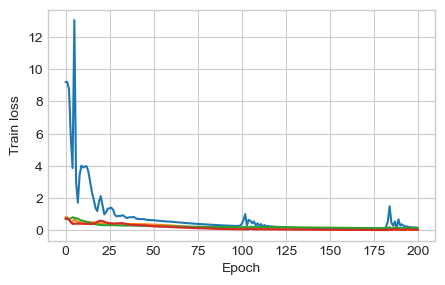

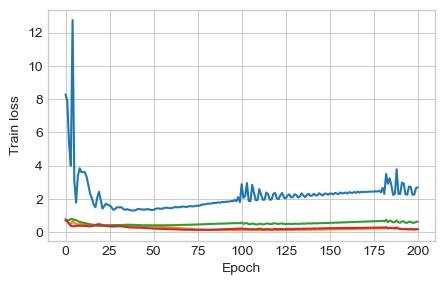

In [13]:
plot_convergence(model.train_log)
plot_convergence(model.val_log)

Get outputs for comparison

Take `expit` of the model outputs for classifiers.

In [14]:
_y_est = model(x_train_t)
_y_est[:,col_class] = torch.sigmoid(_y_est[:,col_class])
y_train_est["mltnn"] = _y_est.detach().numpy()

_y_est = model(x_test_t)
_y_est[:,col_class] = torch.sigmoid(_y_est[:,col_class])
y_test_est["mltnn"] = _y_est.detach().numpy()


Check:
* model weights vary between the output heads
* embedding is training

## Evaluation

In [15]:
import sklearn.metrics

train_loss = {}
test_loss = {}
for _name, val in y_train_est.items():
    train_loss[_name] = []
    for _col in range(max(col_reg + col_class)+1):
        if _col in col_reg:
            train_loss[_name].append(
                sklearn.metrics.mean_squared_error(y_train[:, _col], y_pred=val[:, _col])
            )
        elif _col in col_class:
            train_loss[_name].append(
                sklearn.metrics.log_loss(y_train[:, _col], y_pred=val[:, _col])
            )

for _name, val in y_test_est.items():
    test_loss[_name] = []
    for _col in range(max(col_reg + col_class)+1):
        if _col in col_reg:
            test_loss[_name].append(
                sklearn.metrics.mean_squared_error(y_test[:, _col], y_pred=val[:, _col])
            )
        elif _col in col_class:
            test_loss[_name].append(
                sklearn.metrics.log_loss(y_test[:, _col], y_pred=val[:, _col])
            )

print("train loss")
display(train_loss)
print("test loss")
display(test_loss)


train loss


{'linear': [0.919367664523596,
  0.09926108916530882,
  0.2836393356892871,
  0.08531516284309643],
 'gbm': [0.24136609426549382,
  0.010782448833677832,
  0.09668363561791535,
  0.008887534450713502],
 'mltnn': [0.15293396398071532,
  0.019448581744472507,
  0.1348979974473569,
  0.01836932224599758]}

test loss


{'linear': [1.144916989721128,
  0.10983314049400753,
  0.35003538261536443,
  0.10618248641387754],
 'gbm': [2.4404799622038413,
  0.19782450870922264,
  0.5095195791572817,
  0.17545397489746034],
 'mltnn': [2.6880218474585456,
  0.16109993028830816,
  0.618585706158369,
  0.17078155107312176]}

# Todo
* Show within https://netron.app/?url=https://media.githubusercontent.com/media/onnx/models/main/vision/classification/squeezenet/model/squeezenet1.0-3.onnx